<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;"> Treball Final de Master</p>
<p style="margin: 0; text-align:right;"> 20241 - Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;"> Estudis d'Informàtica, Multimedia i Telecomunicacions</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

<b>Arnau Gusart Verdú</b>


# Analysis and prediction of soil humidity in small holding vineyards.

This notebook contains the code and some light explanations for the TFM project.


In [ ]:
# Libraries Used
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
import re
import seaborn as sns
import scipy.stats as stats
from scipy.stats import anderson
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


%matplotlib inline
# Per carregar les dades
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')
os.listdir('/content/drive/My Drive/')
os.chdir('/content/drive/MyDrive/Colab Notebooks/TFM/')

Mounted at /content/drive


## 1.- Creation of the dataset

Creation of datasets for each sensor using the distinct .csv files.

In [ ]:
# Path to the folder containing CSV files
folder_path = '/content/drive/MyDrive/Colab Notebooks/TFM/data/'

# Initialize a dictionary to store DataFrames for each sensor
sensor_dataframes = {}

# Loop through all files
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # only CSV files
        # Extract sensor code and column name with regex
        match = re.match(r"(.+?)_(.+)\.csv", file_name)
        if match:
            sensor_code = match.group(1)
            column_name = match.group(2)
            # Check if its one of the 4 nodes of interest
            if sensor_code not in ('46005a000351353337353037', '270043001951343334363036', '380033001951343334363036', '4e0031000251353337353037'):
                continue
        else:
            print(f"Skipping file {file_name} due to invalid file name format.")
            continue

        file_path = os.path.join(folder_path, file_name)

        if column_name == 'wind_direction_raw':
            # Handle wind direction files (it has a different format)
            temp_df = pd.read_csv(file_path, names=['time', 'sensor_code', 'direction', 'range'])
            temp_df = temp_df[['time', 'direction', 'range']]
        else:
            # Default format
            temp_df = pd.read_csv(file_path, names=['time', column_name])

        if sensor_code not in sensor_dataframes:
            sensor_dataframes[sensor_code] = []

        temp_df['time'] = pd.to_datetime(temp_df['time'], errors='coerce')
        sensor_dataframes[sensor_code].append(temp_df)

# Merge all sensor DataFrames by time
for sensor_code, dfs in sensor_dataframes.items():
    merged_df = pd.concat(dfs, axis=1).loc[:,~pd.concat(dfs, axis=1).columns.duplicated()]
    merged_df = merged_df.loc[:,~merged_df.columns.str.contains('^time')]
    merged_df['time'] = dfs[0]['time']

    sensor_dataframes[sensor_code] = merged_df

for sensor_code, df in sensor_dataframes.items():
    print(f"Data for sensor {sensor_code}:")
    print(df.head(), "\n")


<ipython-input-8-2305fb0d75d8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['time'] = pd.to_datetime(temp_df['time'], errors='coerce')


Data for sensor 46005a000351353337353037:
   soil_humidity_raw  humidity_raw  atmospheric_pressure_raw  \
0             3883.0     54.516357                984.222473   
1              304.0     54.302734                984.257507   
2             3117.0     57.072205                984.377502   
3             3219.0     58.575195                  0.000000   
4             3285.0     69.553894                983.794983   

   air_temperature_raw  precipitation_raw  battery_raw     direction  range  \
0            31.378862                0.0    86.203125  1.535022e+09   -1.0   
1            31.078560                0.0    85.769531  1.535022e+09   -1.0   
2            30.102575                0.0    82.703125  1.535023e+09   -1.0   
3            29.512695                0.0    83.031250  1.535024e+09   -1.0   
4            28.654688                0.0    82.703125  1.535030e+09    0.0   

   wind_speed_raw                    time  
0         0.00000 2018-08-23 13:07:11.783  
1         

In [ ]:
# Check for null values for each sensor
for sensor_code, df in sensor_dataframes.items():
    print(f"Null values in DataFrame for sensor {sensor_code} ({len(df.index)} rows):")
    print(df.isnull().sum())
    print("\n")

Null values in DataFrame for sensor 46005a000351353337353037 (5828 rows):
soil_humidity_raw           29
humidity_raw                 4
atmospheric_pressure_raw    20
air_temperature_raw          0
precipitation_raw            8
battery_raw                 35
direction                   11
range                       11
wind_speed_raw              16
time                        29
dtype: int64


Null values in DataFrame for sensor 380033001951343334363036 (19906 rows):
air_temperature_raw           0
humidity_raw                 51
soil_humidity_raw           426
precipitation_raw            96
battery_raw                 538
atmospheric_pressure_raw    285
direction                   150
range                       150
wind_speed_raw              200
time                          0
dtype: int64


Null values in DataFrame for sensor 270043001951343334363036 (20214 rows):
humidity_raw                 34
atmospheric_pressure_raw    291
precipitation_raw            69
battery_raw         

Extraction of null counts for a table.

In [ ]:
table_data = []

for sensor_code, df in sensor_dataframes.items():
    null_counts = df.isnull().sum()
    row = {
        "Sensor Code": sensor_code,
        "Row Count": len(df),
    }
    # Add null counts
    for column, null_count in null_counts.items():
        row[column] = null_count
    table_data.append(row)


table_df = pd.DataFrame(table_data)
transposed_table_df = table_df.set_index("Sensor Code").T

# Export the transposed table to LaTeX
with open("/content/drive/MyDrive/Colab Notebooks/TFM/tables/null_table.tex", "w") as f:
    f.write(transposed_table_df.to_latex(index=True, header=True, caption="Transposed Table of Sensor Null Values"))


Vertical join of the four distinct sensor dfs into one.

In [ ]:
vertical_concat_dfs = []

for sensor_code, df in sensor_dataframes.items():
    df['sensor_code'] = sensor_code
    vertical_concat_dfs.append(df)

# Join dfs
merged_df = pd.concat(vertical_concat_dfs, axis=0)
cols = ['time'] + ['sensor_code'] + [col for col in merged_df.columns if col != 'sensor_code' and col != 'time']
merged_df = merged_df[cols]

# Drop rows with any null values
merged_df = merged_df.dropna()

# Reset the index for clarity
merged_df.reset_index(drop=True, inplace=True)

# Define the sensor code map (we use simple labels)
sensor_code_map = {
    '380033001951343334363036': 'A',
    '270043001951343334363036': 'B',
    '4e0031000251353337353037': 'C',
    '46005a000351353337353037': 'D'
}
merged_df['sensor_code'] = merged_df['sensor_code'].replace(sensor_code_map)

print("Merged DataFrame:")
print(merged_df.head())
print(len(merged_df.index))


Merged DataFrame:
                     time sensor_code  soil_humidity_raw  humidity_raw  \
0 2018-08-23 13:07:11.783           D             3883.0     54.516357   
1 2018-08-23 13:17:37.242           D              304.0     54.302734   
2 2018-08-23 13:37:40.126           D             3117.0     57.072205   
3 2018-08-23 15:05:16.805           D             3219.0     58.575195   
4 2018-08-23 15:15:39.859           D             3285.0     69.553894   

   atmospheric_pressure_raw  air_temperature_raw  precipitation_raw  \
0                984.222473            31.378862                0.0   
1                984.257507            31.078560                0.0   
2                984.377502            30.102575                0.0   
3                  0.000000            29.512695                0.0   
4                983.794983            28.654688                0.0   

   battery_raw     direction  range  wind_speed_raw  
0    86.203125  1.535022e+09   -1.0         0.00000  
1 

## 2.- Data Analysis

First of all we proceed in removing redundant columns, nulls and undefined measurements.

In [ ]:
# Count rows where 'range' is -1 (-1 means undefined)
count_range_minus_1 = merged_df[merged_df['range'] == -1].shape[0]
print(f"Number of rows with range = -1: {count_range_minus_1}")

# Remove rows
merged_df = merged_df[merged_df['range'] != -1]

print(merged_df.head())


Number of rows with range = -1: 6392
                     time sensor_code  soil_humidity_raw  humidity_raw  \
4 2018-08-23 15:15:39.859           D             3285.0     69.553894   
5 2018-08-23 15:25:39.571           D             3301.0     62.313599   
6 2018-08-23 15:35:40.761           D             3288.0     60.963196   
7 2018-08-23 15:45:40.334           D             3298.0     57.766479   
8 2018-08-23 15:55:39.974           D             3362.0     58.743042   

   atmospheric_pressure_raw  air_temperature_raw  precipitation_raw  \
4                983.794983            28.654688             0.0000   
5                983.719971            30.939133             3.0734   
6                983.729980            30.585205             0.0000   
7                986.539978            28.761938             0.0000   
8                985.567505            29.941700             1.9558   

   battery_raw     direction  range  wind_speed_raw  
4    82.703125  1.535030e+09    0.0  

In [ ]:
# Drop the 'direction' column (its redundant)
merged_df = merged_df.drop(columns=['direction'], errors='ignore')

In [ ]:
summary = merged_df.describe() # Extraction for a table
transposed_summary = summary.T

# Export the summary table to a LaTeX file
with open("/content/drive/MyDrive/Colab Notebooks/TFM/tables/merged_df_description.tex", "w") as f:
    f.write(transposed_summary.to_latex(index=True, caption="Summary Statistics of Merged DataFrame"))

Different kinds of plots to observe patterns in data.

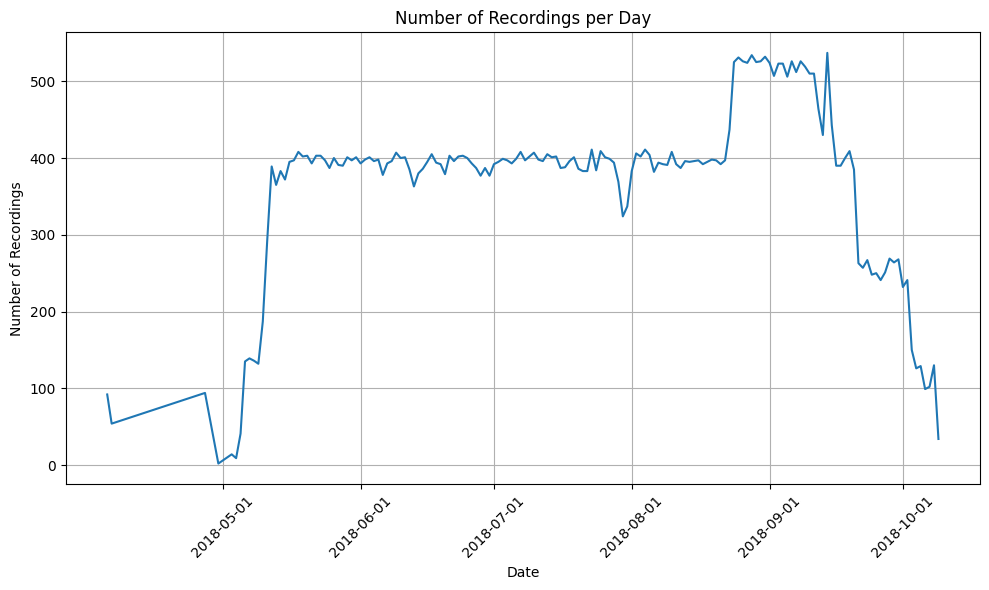

In [ ]:
# Plot the number of measurements per day
df_copy = merged_df.copy()

df_copy['date'] = df_copy['time'].dt.date
daily_recordings = df_copy.groupby('date').size()
plt.figure(figsize=(10, 6))
daily_recordings.plot()

monthly_ticks = pd.date_range(start=daily_recordings.index.min(),
                              end=daily_recordings.index.max(),
                              freq='MS')

plt.xticks(monthly_ticks, rotation=45)
plt.title('Number of Recordings per Day')
plt.xlabel('Date')
plt.ylabel('Number of Recordings')
plt.grid(True)
plt.tight_layout()
plt.show()


Here we observe the number of measurements per day. We see an almost even distribution of arround 400 measurements starting on may.

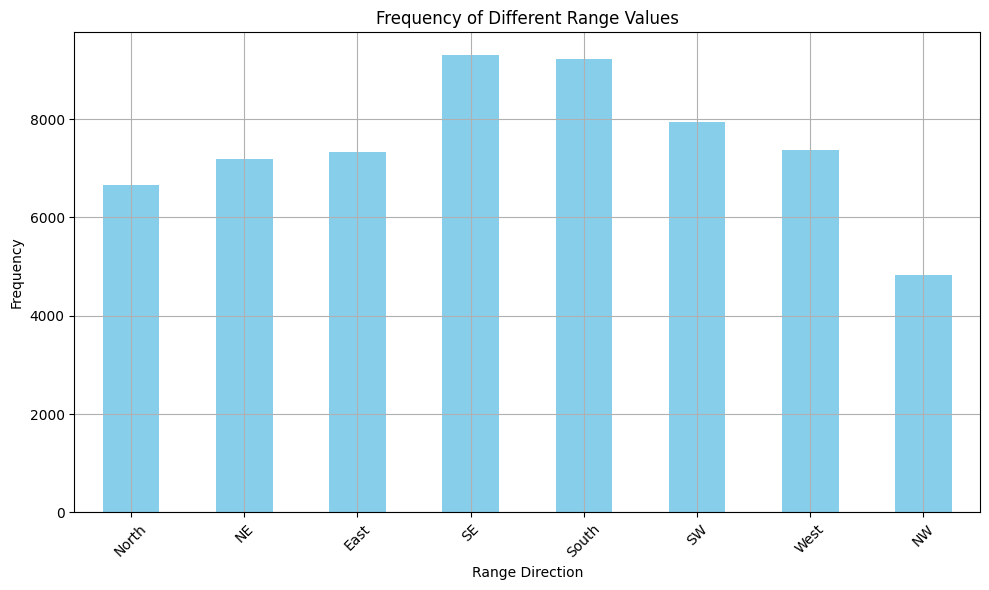

In [ ]:
# Plot of the number of measurements per wind direction
range_labels = {
    0: 'North',
    1: 'NE',
    2: 'East',
    3: 'SE',
    4: 'South',
    5: 'SW',
    6: 'West',
    7: 'NW'
}

df_copy['range_label'] = df_copy['range'].map(range_labels)

# Preserve the order for the plot
df_copy['range_label'] = pd.Categorical(df_copy['range_label'], categories=['North', 'NE', 'East', 'SE', 'South', 'SW', 'West', 'NW'], ordered=True)
plt.figure(figsize=(10, 6))

range_counts = df_copy['range_label'].value_counts().sort_index()
range_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Different Range Values')
plt.xlabel('Range Direction')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


There is an almost even distribution of data in all categories, having some more measurements for SE and S and noticeably less in NW.

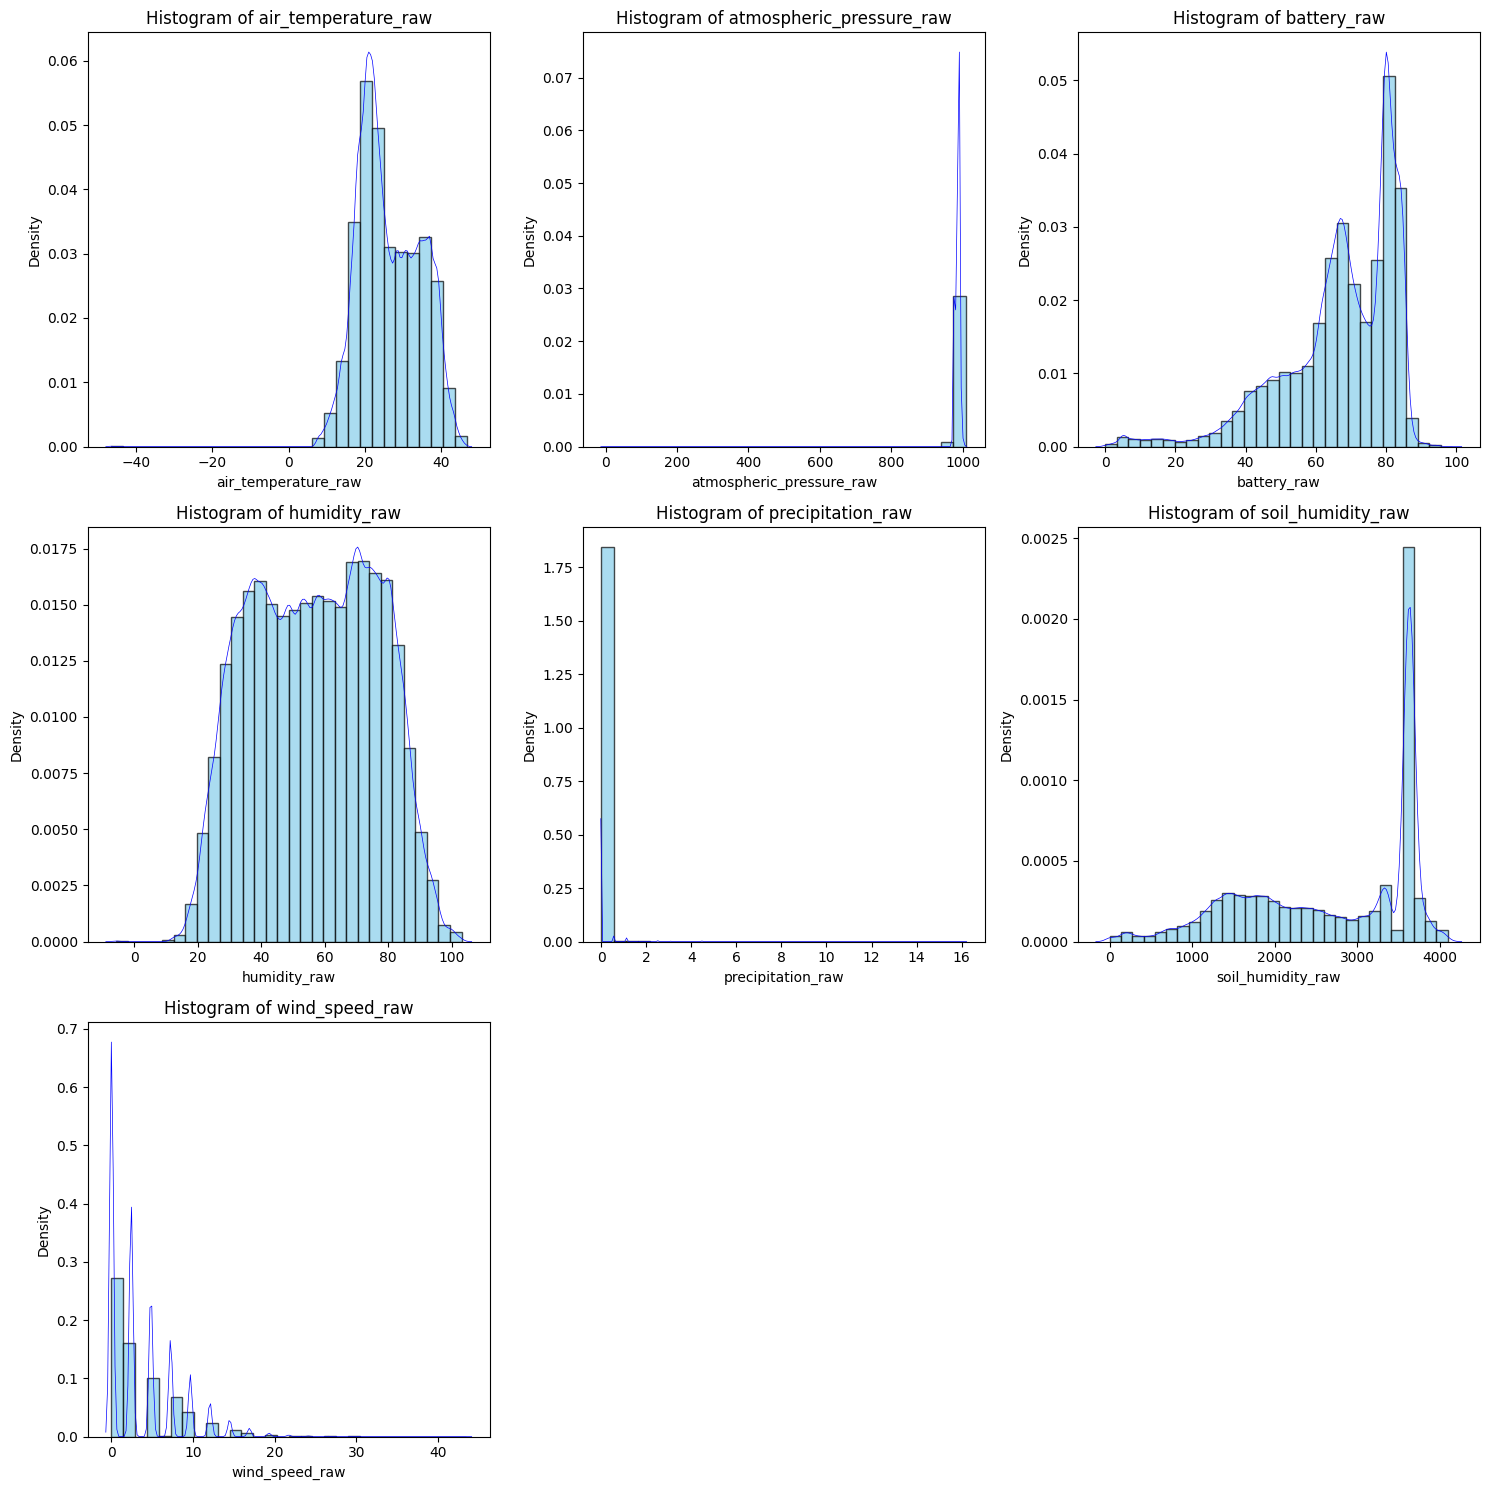

In [ ]:

# Select numeric columns excluding 'sensor_code', 'time', and 'range'
numeric_columns = df_copy.select_dtypes(include=['float64', 'int64']).columns.difference(['sensor_code', 'time', 'range'])

n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Calculate number of rows needed for the multiplot

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Plot the histogram
    axes[i].hist(df_copy[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=True)
    # Plot the KDE line
    sns.kdeplot(df_copy[col], ax=axes[i], color='blue', linewidth=0.5, bw_adjust=0.5)

    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Hide empty subplots
for i in range(len(numeric_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Rough examination to see if the data has normal distribution. We see that it does not appear to be the case.

In [ ]:
# Perform Anderson-Darling test for each numeric column
anderson_results = {}
for col in numeric_columns:
    result = anderson(df_copy[col].dropna())  # Drop null values before the test
    anderson_results[col] = {'statistic': result.statistic, 'critical_values': result.critical_values, 'significance_level': result.significance_level}

for col, result in anderson_results.items():
    print(f'{col}: Anderson-Darling Statistic = {result["statistic"]:.4f}')
    for i, cv in enumerate(result["critical_values"]):
        print(f'  {result["significance_level"][i]}% critical value: {cv:.4f}')
    if result["statistic"] < result["critical_values"][2]:  # Compare with the 5% critical value
        print(f'{col} appears to be normally distributed.')
    else:
        print(f'{col} does not appear to be normally distributed.')


air_temperature_raw: Anderson-Darling Statistic = 655.1556
  15.0% critical value: 0.5760
  10.0% critical value: 0.6560
  5.0% critical value: 0.7870
  2.5% critical value: 0.9180
  1.0% critical value: 1.0920
air_temperature_raw does not appear to be normally distributed.
atmospheric_pressure_raw: Anderson-Darling Statistic = 9851.7832
  15.0% critical value: 0.5760
  10.0% critical value: 0.6560
  5.0% critical value: 0.7870
  2.5% critical value: 0.9180
  1.0% critical value: 1.0920
atmospheric_pressure_raw does not appear to be normally distributed.
battery_raw: Anderson-Darling Statistic = 1588.0518
  15.0% critical value: 0.5760
  10.0% critical value: 0.6560
  5.0% critical value: 0.7870
  2.5% critical value: 0.9180
  1.0% critical value: 1.0920
battery_raw does not appear to be normally distributed.
humidity_raw: Anderson-Darling Statistic = 463.4194
  15.0% critical value: 0.5760
  10.0% critical value: 0.6560
  5.0% critical value: 0.7870
  2.5% critical value: 0.9180
  1.0

After applying the Anderson-Darling test (better fit than Shapiro-Wilk as the dataset is bigger), it confirms that none of the numerical columns follow a Normal distribution.

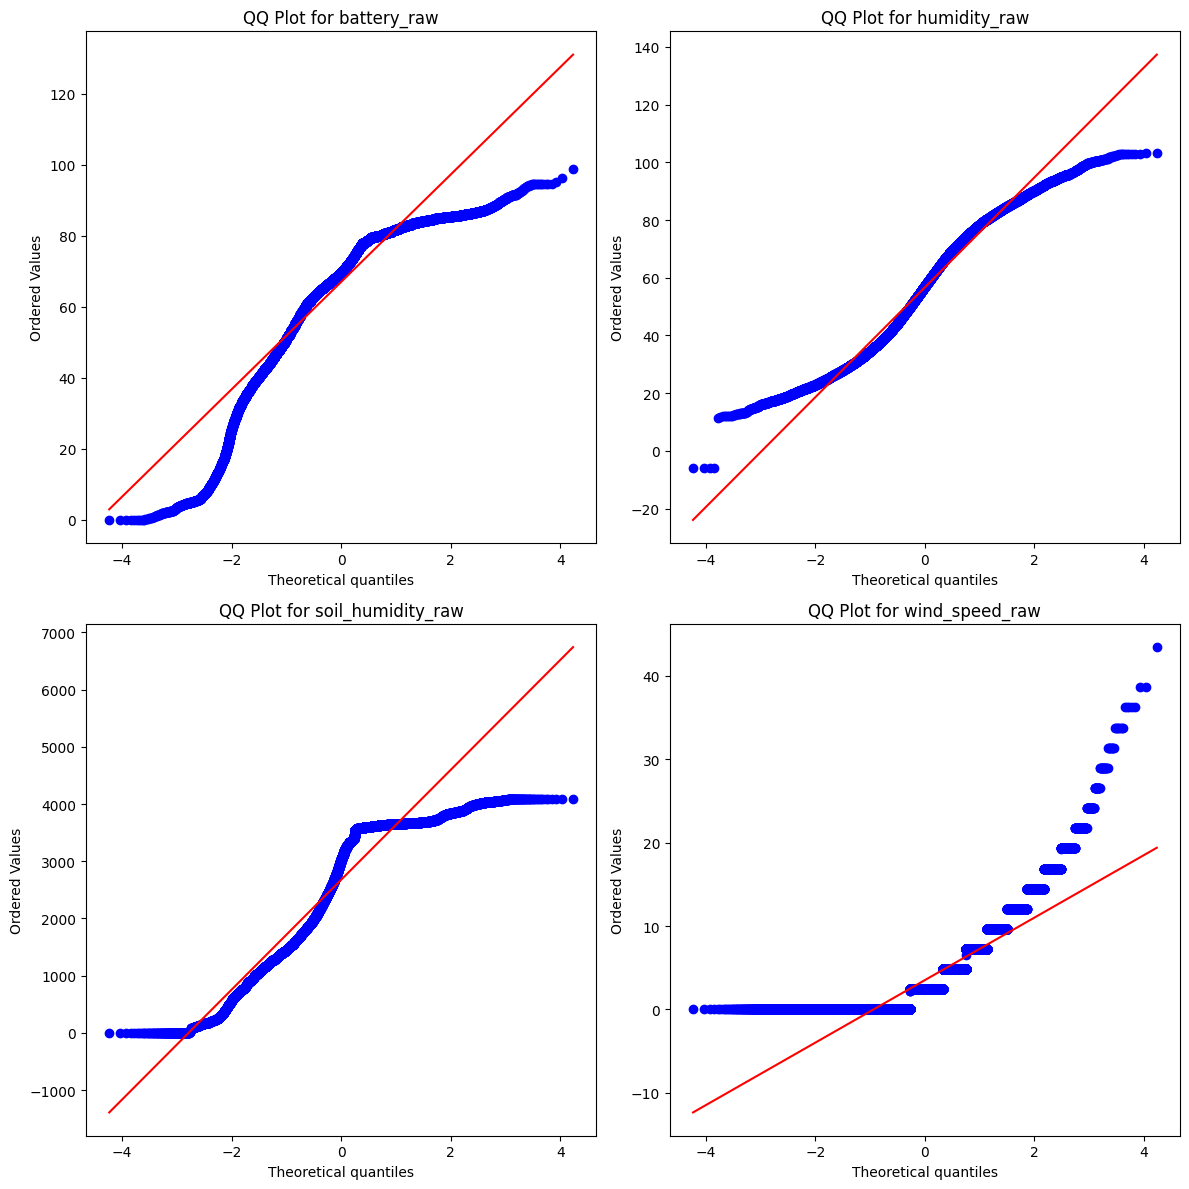

In [ ]:
# Columns of interest
columns_to_plot = ['battery_raw', 'humidity_raw', 'soil_humidity_raw', 'wind_speed_raw']

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i, col in enumerate(columns_to_plot):
    stats.probplot(df_copy[col].dropna(), dist="norm", plot=axs[i])
    axs[i].set_title(f'QQ Plot for {col}')

plt.tight_layout()
plt.show()

We double check with a QQ-plots and see that in the extremes the data differs greatly from the normal "expectation".

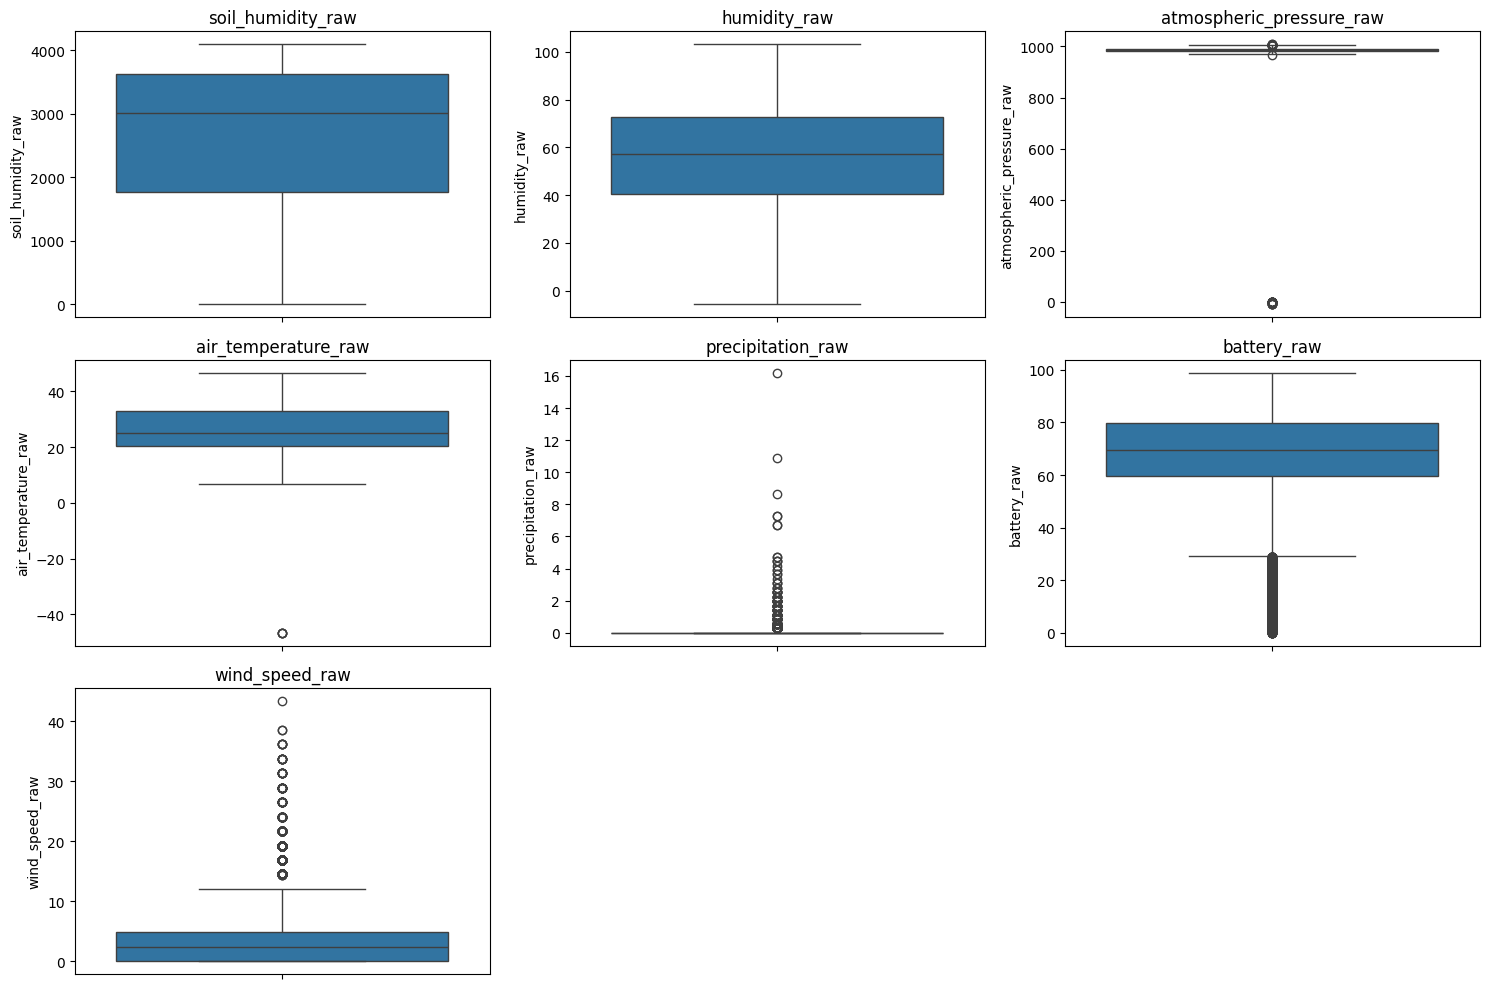

In [ ]:
# Calculate the number of rows and columns for the grid
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Create a box plot for each variable
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=df_copy[col], ax=axes[i])
    axes[i].set_title(col)

for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


We notice that there are outliers with unrealistic values in atmospheric pressure so we remove the rows. (Setting the minimum to the lowest measured pressure in Spain).

In [ ]:
# Remove outliers with unrealistic values
merged_df = merged_df[merged_df['atmospheric_pressure_raw'] >= 950]
df_copy = df_copy[df_copy['atmospheric_pressure_raw'] >= 950]

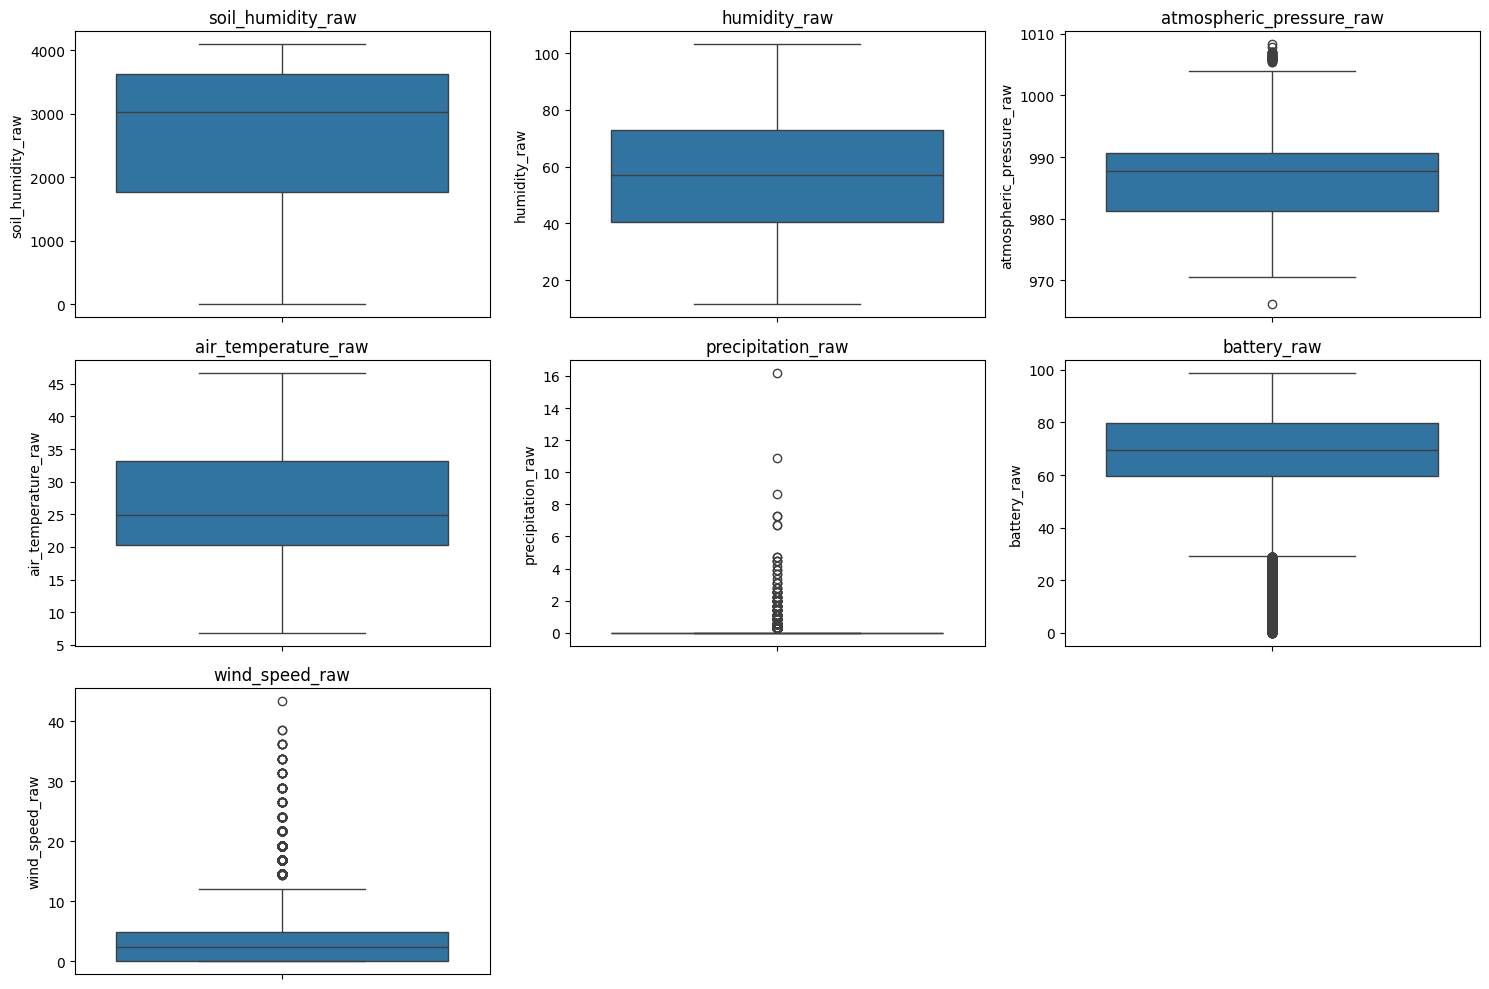

In [ ]:
# Calculate the number of rows and columns for the grid
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Create a box plot for each variable
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=df_copy[col], ax=axes[i])
    axes[i].set_title(col)

for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


We see that it also seems to have removed some temperature outliers.

<ipython-input-13-7ba028a74ecb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['sensor_code'] = pd.Categorical(df_copy['sensor_code'], categories=sensor_order, ordered=True)
<ipython-input-13-7ba028a74ecb>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_copy, x='sensor_code', y=col, ax=axes[i], palette=palette)
<ipython-input-13-7ba028a74ecb>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_copy, x='sensor_code', y=col, a

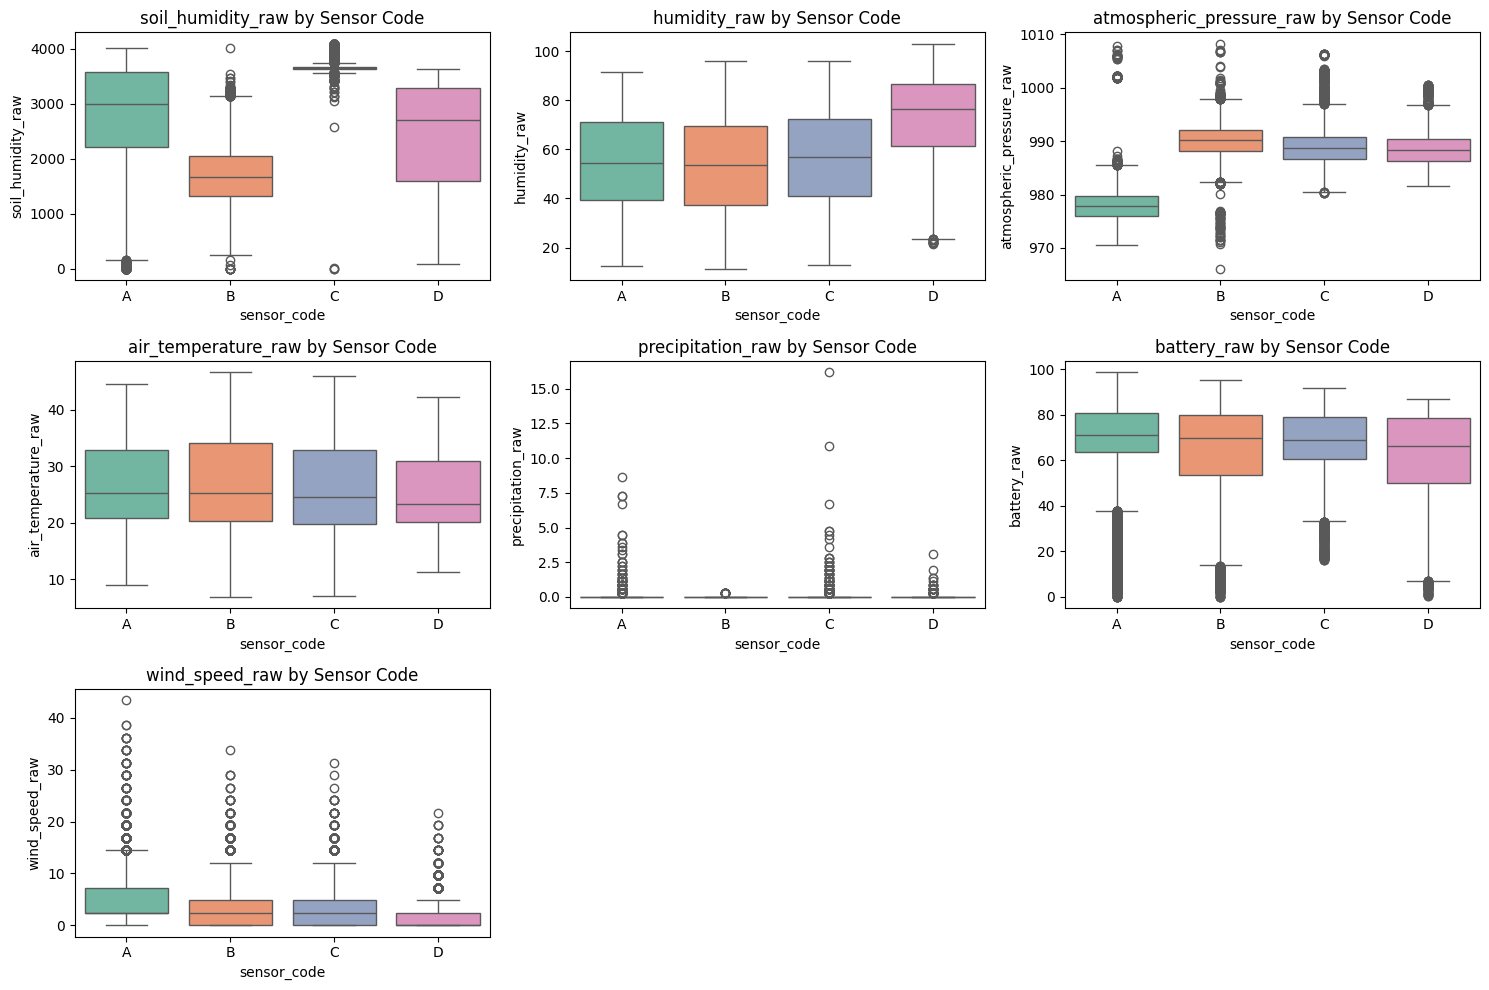

In [ ]:
sensor_order = ['A', 'B', 'C', 'D']
df_copy['sensor_code'] = pd.Categorical(df_copy['sensor_code'], categories=sensor_order, ordered=True)

n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Define color
palette = sns.color_palette("Set2", len(sensor_order))

# Create a box plot for each numeric column, separated by 'sensor_code'
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=df_copy, x='sensor_code', y=col, ax=axes[i], palette=palette)
    axes[i].set_title(f'{col} by Sensor Code')

for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

We repeat the boxplots now using the differenciating by sensor to check for different behaviours. Like for sensor C and soil humidity, and A and atmospheric pressure. We also check for differences in categorical variables.

<ipython-input-140-13bfd7c1284c>:13: UserWarning: The palette list has more values (24) than needed (4), which may not be intended.
  sns.countplot(data=df_copy, x='range', hue='sensor_code', palette=palette)


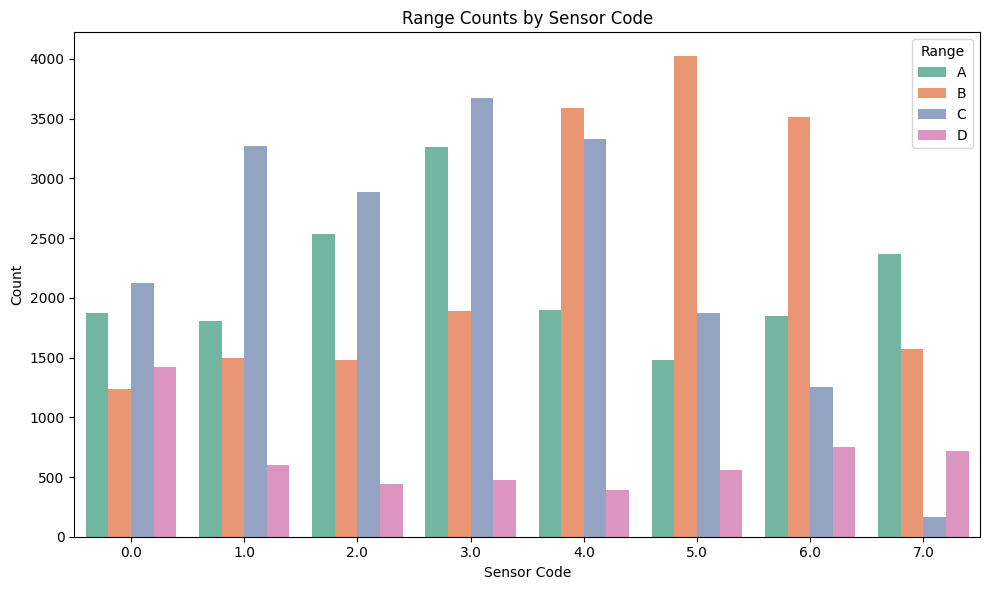

In [ ]:
# Plot the count of each range value by sensor code
plt.figure(figsize=(10, 6))
sns.countplot(data=df_copy, x='range', hue='sensor_code', palette=palette)

plt.title('Range Counts by Sensor Code')
plt.xlabel('Sensor Code')
plt.ylabel('Count')
plt.legend(title='Range', loc='upper right')

plt.tight_layout()
plt.show()


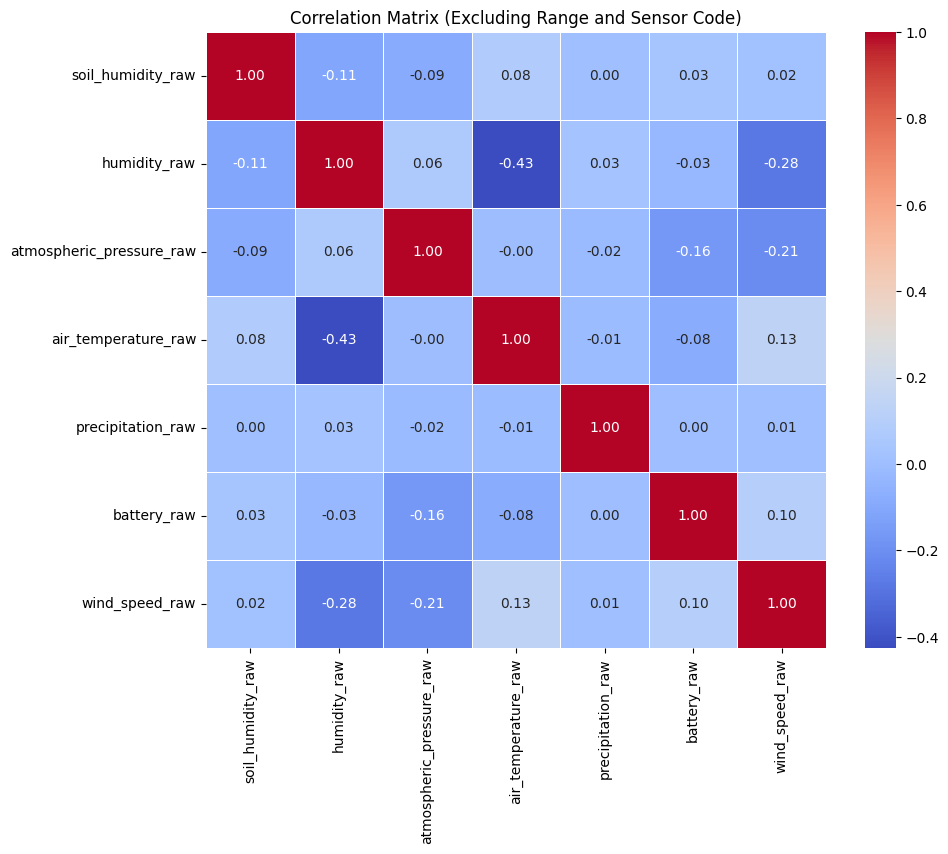

In [ ]:
# Calculate correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Excluding Range and Sensor Code)')
plt.show()

In [ ]:
# List of numerical variables to perform ANOVA to check statistical significance between variables
numerical_columns = ['soil_humidity_raw', 'humidity_raw', 'atmospheric_pressure_raw',
                     'air_temperature_raw', 'precipitation_raw', 'battery_raw', 'wind_speed_raw']

# Perform ANOVA test for each numerical variable grouped by 'sensor_code' and 'range'
anova_results = {}

# ANOVA for 'sensor_code'
for column in numerical_columns:
    groups = [merged_df[merged_df['sensor_code'] == sensor_code][column]
              for sensor_code in merged_df['sensor_code'].unique()]
    f_stat, p_val = f_oneway(*groups)
    anova_results[f'sensor_code_{column}'] = {'F-statistic': f_stat, 'p-value': p_val}

# ANOVA for 'range'
for column in numerical_columns:
    groups = [merged_df[merged_df['range'] == range_value][column]
              for range_value in merged_df['range'].unique()]
    f_stat, p_val = f_oneway(*groups)
    anova_results[f'range_{column}'] = {'F-statistic': f_stat, 'p-value': p_val}

# Print the results
alpha = 0.05

print("ANOVA Results (alpha = 0.05):\n")

for test, result in anova_results.items():
    f_stat = result['F-statistic']
    p_val = result['p-value']

    print(f"{test}:")
    print(f"  F-statistic: {f_stat:.3f}")
    print(f"  p-value: {p_val:.3f}")

    if p_val < alpha:
        print(f"  Conclusion: Statistically significant (p < {alpha})\n")
    else:
        print(f"  Conclusion: Not statistically significant (p >= {alpha})\n")


ANOVA Results (alpha = 0.05):

sensor_code_soil_humidity_raw:
  F-statistic: 26237.474
  p-value: 0.000
  Conclusion: Statistically significant (p < 0.05)

sensor_code_humidity_raw:
  F-statistic: 1631.196
  p-value: 0.000
  Conclusion: Statistically significant (p < 0.05)

sensor_code_atmospheric_pressure_raw:
  F-statistic: 48036.502
  p-value: 0.000
  Conclusion: Statistically significant (p < 0.05)

sensor_code_air_temperature_raw:
  F-statistic: 77.009
  p-value: 0.000
  Conclusion: Statistically significant (p < 0.05)

sensor_code_precipitation_raw:
  F-statistic: 17.430
  p-value: 0.000
  Conclusion: Statistically significant (p < 0.05)

sensor_code_battery_raw:
  F-statistic: 438.931
  p-value: 0.000
  Conclusion: Statistically significant (p < 0.05)

sensor_code_wind_speed_raw:
  F-statistic: 1185.008
  p-value: 0.000
  Conclusion: Statistically significant (p < 0.05)

range_soil_humidity_raw:
  F-statistic: 420.145
  p-value: 0.000
  Conclusion: Statistically significant (p <

Both sensor code and range appear to have statistical significance and regecting the Null hypothesis.

We take houly averages to check for time related behaviour, the different lines represent different days.

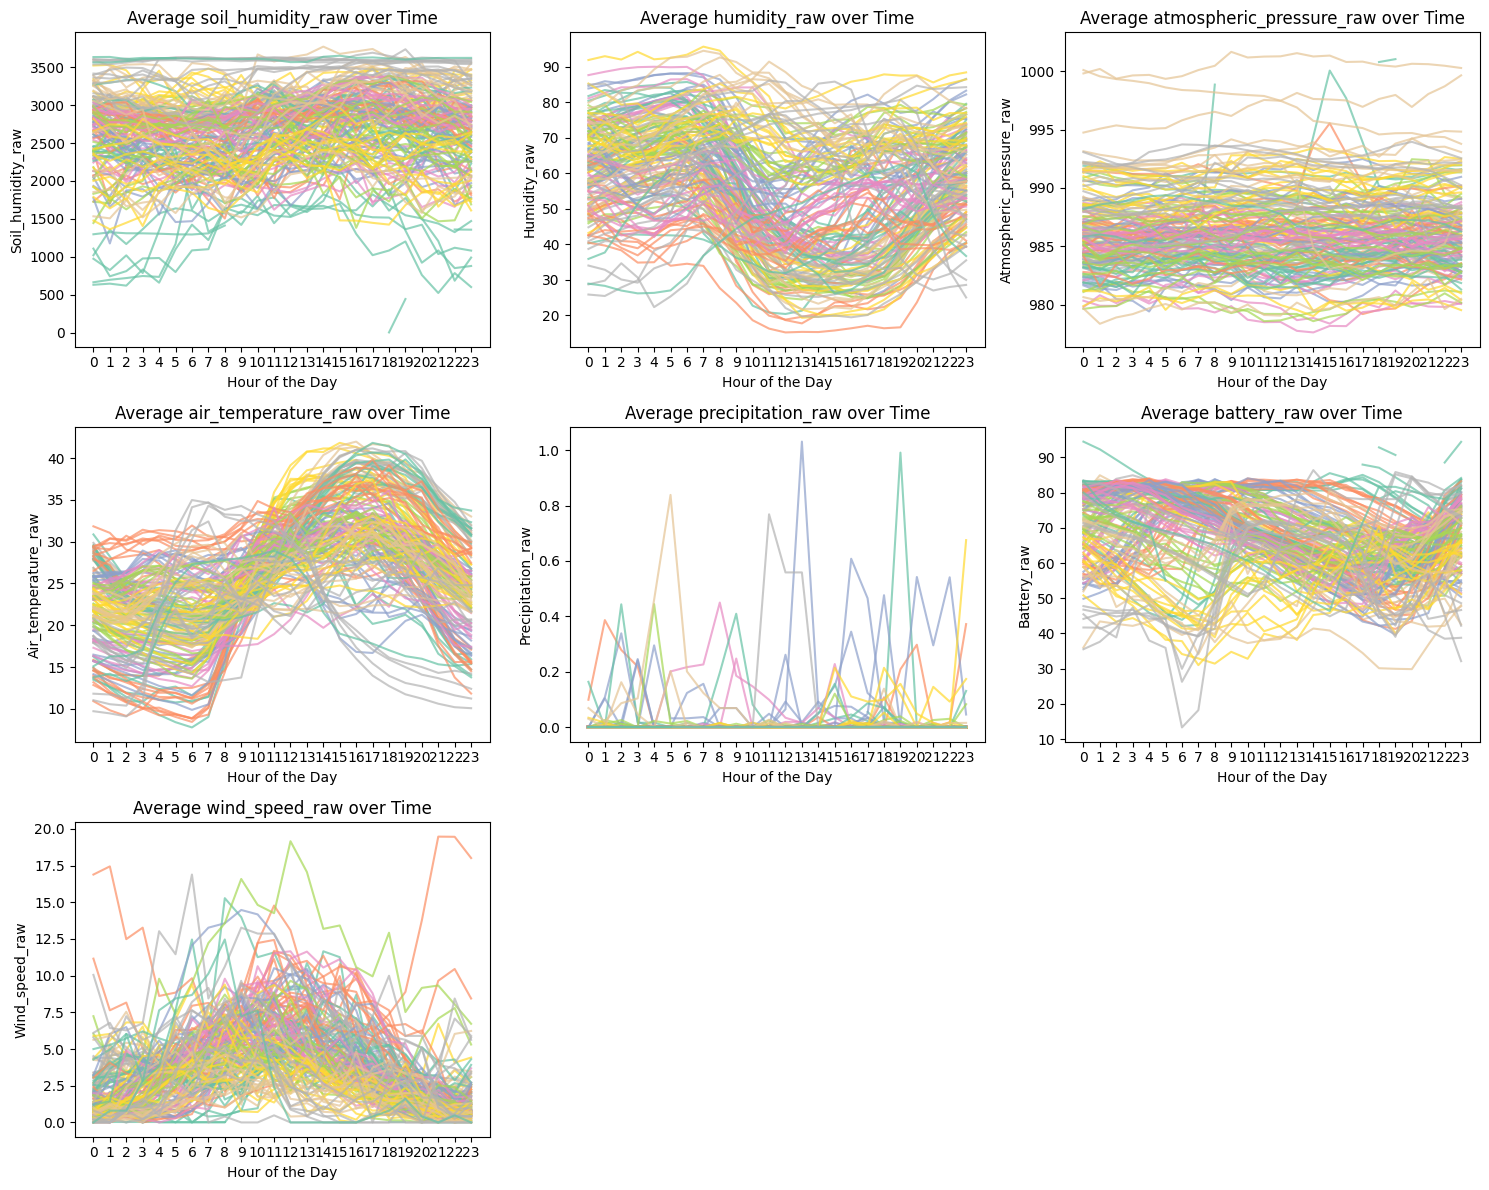

In [ ]:
merged_df['time'] = merged_pd.to_datetime(merged_df['time'])
merged_df['date'] = merged_df['time'].dt.date         # Extract the date (yyyy-mm-dd)
merged_df['hour'] = merged_df['time'].dt.hour         # Extract the hour (0-23)

# Calculate hourly averages
hourly_avg = merged_df.groupby(['date', 'hour']).mean().reset_index()

hourly_avg = hourly_avg[hourly_avg['atmospheric_pressure_raw'] >= 950]
hourly_avg = hourly_avg[hourly_avg['atmospheric_pressure_raw'] <= 1050]

# Color palette
bright_palette = sns.color_palette("Set2", n_colors=(len(hourly_avg['date'].unique()) // 10) + 1)

hourly_avg['date'] = pd.to_datetime(hourly_avg['date'])

plt.figure(figsize=(15, 12))

for i, column in enumerate(numeric_columns):
    if column == 'hour': continue
    plt.subplot(3, 3, i+1)  # 3x3 grid

    sorted_dates = sorted(hourly_avg['date'].unique())

    for idx, date in enumerate(sorted_dates):
        group_index = idx // 10
        color = bright_palette[group_index % len(bright_palette)]

        daily_avg = hourly_avg[hourly_avg['date'] == date]

        plt.plot(daily_avg['hour'], daily_avg[column], color=color, alpha=0.7)

    plt.title(f'Average {column} over Time')
    plt.xlabel('Hour of the Day')
    plt.ylabel(f'{column.capitalize()}')
    plt.xticks(np.arange(0, 24, step=1))  # Display hours from 0 to 23

plt.tight_layout()

plt.show()


Noticeable behaviours:
- Drop in humidity during the day.
- Increase in temperature during the day.
- Constant atmospheric pressure.
- Very herratic precipitation.

Plot of the two variables with the most (negative) correlation.

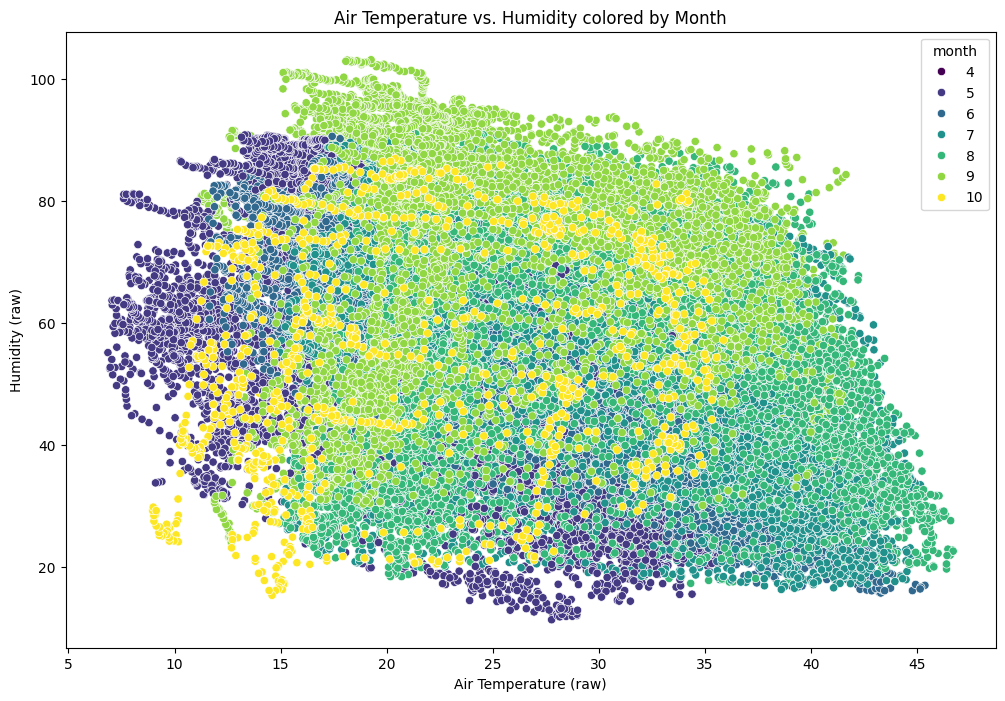

In [ ]:
# Extract the month from the 'time' column
merged_df['month'] = merged_df['time'].dt.month

plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='air_temperature_raw', y='humidity_raw', hue='month', palette='viridis')
plt.title('Air Temperature vs. Humidity colored by Month')
plt.xlabel('Air Temperature (raw)')
plt.ylabel('Humidity (raw)')
plt.show()

## 3.- Data Modeling

In [ ]:
merged_df.describe()

time  soil_humidity_raw  humidity_raw  \
count                          59814       59814.000000  59814.000000   
mean   2018-07-22 08:35:45.775874560        2676.293761     56.704038   
min       2018-04-05 21:37:17.255000           0.000000     11.379761   
25%    2018-06-15 17:08:38.429750016        1773.000000     40.325684   
50%    2018-07-23 14:11:53.329499904        3022.000000     57.079834   
75%    2018-08-28 23:15:11.474749952        3623.000000     72.857422   
max       2018-10-09 05:55:17.980000        4095.000000    103.146118   
std                              NaN        1025.463879     19.294970   

       atmospheric_pressure_raw  air_temperature_raw  precipitation_raw  \
count              59814.000000         59814.000000       59814.000000   
mean                 986.223991            26.403537           0.006213   
min                  966.104980             6.861289           0.000000   
25%                  981.310624            20.246210           0.000000   
50%                  987.727478            24.890179           0.000000   
75%                  990.619995            33.116329           0.000000   
max                 1008.294983            46.694302          16.205196   
std                    6.153630             7.950200           0.138051   

        battery_raw         range  wind_speed_raw  
count  59814.000000  59814.000000    59814.000000  
mean      67.029714      3.414568        3.519540  
min        0.000000      0.000000        0.000000  
25%       59.476563      2.000000        0.000000  
50%       69.625000      3.000000        2.412060  
75%       79.933594      5.000000        4.824121  
max       98.925781      7.000000       43.417084  
std       15.993068      2.125251        4.180872

We prepare the data for the training and testing of models.

In [ ]:
# Set the objective variable as 'soil_humidity_raw'
obj_variable = 'soil_humidity_raw'

# Extract month and hour from the 'time' variable
merged_df['month'] = merged_df['time'].dt.month
merged_df['hour'] = merged_df['time'].dt.hour

# Separate features (X) and target (y)
X = merged_df.drop(columns=['time', obj_variable])
y = merged_df[obj_variable]


categorical_columns = ['month', 'hour', 'range', 'sensor_code']
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = [col for col in numeric_columns if col not in categorical_columns]

scaler = RobustScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))  # Reshape y to be a 2D array

X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

y_train = pd.DataFrame({'soil_humidity_raw': np.ravel(y_train)})
y_test = pd.DataFrame({'soil_humidity_raw': np.ravel(y_test)})

# Save the processed data as CSV
X_train.to_csv('/content/drive/MyDrive/Colab Notebooks/TFM/train/X_train.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/Colab Notebooks/TFM/train/X_test.csv', index=False)

y_train.to_csv('/content/drive/MyDrive/Colab Notebooks/TFM/train/y_train.csv', index=False, header=False)
y_test.to_csv('/content/drive/MyDrive/Colab Notebooks/TFM/train/y_test.csv', index=False, header=False)

print(X_train.head())
print(y_train)
print(f"X_train size: {X_train.shape}")
print(f"y_train size: {y_train.shape}")

      sensor_code  humidity_raw  atmospheric_pressure_raw  \
3417            D      0.799250                  0.362269   
29807           B     -0.054878                 -0.039476   
62968           C      0.828565                  0.546226   
36332           B      0.715056                  0.258883   
33011           B     -0.202158                 -0.282243   

       air_temperature_raw  precipitation_raw  battery_raw  range  \
3417             -0.095000                0.0     0.487875    7.0   
29807            -0.519167                0.0     0.152377    6.0   
62968             0.122500                0.0     0.551652    6.0   
36332            -0.192500                0.0     0.511743    4.0   
33011             0.321667                0.0     0.623449    4.0   

       wind_speed_raw  month  hour  
3417              0.0      9    11  
29807             0.0      6     7  
62968             0.0      9     6  
36332            -0.5      7     6  
33011             1.0      6    1

In [ ]:
X_train.columns

Index(['sensor_code', 'humidity_raw', 'atmospheric_pressure_raw',
       'air_temperature_raw', 'precipitation_raw', 'battery_raw', 'range',
       'wind_speed_raw', 'month', 'hour'],
      dtype='object')

Function for plotting model results with different sample sizes.

In [ ]:
def plot_learning_curves(pipeline, train_X, train_y, cv=3, scoring='r2'):
    """
    Function to plot learning curves for a given pipeline.

    Parameters:
    - pipeline: The machine learning pipeline or model to evaluate.
    - train_X: Features for the training set.
    - train_y: Target variable for the training set.
    - cv: Number of cross-validation splits (default is 5).
    - scoring: The scoring metric to evaluate (default is 'neg_mean_squared_error' for regression).
    """
    # Calculate learning curve data
    train_sizes, train_scores, valid_scores = learning_curve(
        pipeline, train_X, train_y, cv=cv, scoring=scoring
    )

    # Compute mean of training and validation scores
    train_scores_mean = train_scores.mean(axis=1)
    valid_scores_mean = valid_scores.mean(axis=1)

    # Plot the learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label=f'Training {scoring}', color='tab:blue')
    plt.plot(train_sizes, valid_scores_mean, label=f'Validation {scoring}', color='tab:orange')

    plt.ylabel(scoring, fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    plt.title(f'Learning Curves for {str(pipeline)}', fontsize=10, y=1.03)
    plt.legend()
    plt.show()

Function for the definition of pipelines for preprocessing and model fitting.

In [ ]:
def define_pipeline(categorical_pipeline='default',
                    binary_pipeline=None,
                    numerical_pipeline='default',
                    model=None):
    """
    Function to define a pipeline for preprocessing and model fitting.

    Parameters:
    - categorical_pipeline: The pipeline for categorical data (default is 'default').
    - binary_pipeline: The pipeline for binary features (if any) (default is None).
    - numerical_pipeline: The pipeline for numerical data (default is 'default').
    - model: The model to be used.

    Returns:
    - The defined pipeline.
    """
    # Define the transformers for numerical and categorical data
    if numerical_pipeline == 'default':
        numerical_pipeline = Pipeline([
            ('scaler', StandardScaler())  # Standard scaling for numerical features
        ])

    if categorical_pipeline == 'default':
        categorical_pipeline = Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoder for categorical features
        ])

    # Define column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, ['soil_humidity_raw', 'humidity_raw', 'wind_speed_raw', 'air_temperature_raw']),
            ('cat', categorical_pipeline, ['month', 'hour', 'range', 'sensor_code'])
        ])

    # Define pipeline with preprocessing and model
    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return clf

Function for hyperparameter optimization.

In [ ]:
def optimize_hyperparameters(X_train, y_train, model=None, model_grid_values={}, scoring='r2', cv_splits=3):
    """
    Function to optimize hyperparameters for a model pipeline using GridSearchCV.

    Parameters:
    - X_train: The training feature matrix.
    - y_train: The target variable (as a vector, not as a DataFrame).
    - model: The model to be optimized.
    - model_grid_values: Hyperparameter grid for the model.
    - scoring: The scoring metric to optimize (default is 'r2').
    - cv_splits: Number of cross-validation splits (default is 5).

    Returns:
    - The best estimator (model with optimized hyperparameters).
    """

    clf = define_pipeline(model=model)

    grid_search = GridSearchCV(clf, model_grid_values, cv=cv_splits, scoring=scoring, return_train_score=True)

    # Fit the model to the training data (X_train, y_train)
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters found
    print("Best hyperparameters:")
    print(grid_search.best_params_)

    best_scores = pd.DataFrame(grid_search.cv_results_)

    print("\nAvailable metrics in grid search results:")
    print(best_scores.columns)

    if f'mean_test_{scoring}' in best_scores.columns:
        print(f"\nScores for {scoring}:")
        print(f"{scoring}: {best_scores[f'mean_test_{scoring}'].values[0]:.2f}")
    else:
        print(f"\nScoring metric '{scoring}' not found. Available metrics:")
        print(best_scores.columns)

    return grid_search.best_estimator_

### 3.1.- Regression Models

In [ ]:
numeric_cols = [col for col in X_train.columns if not col.startswith(('month_', 'hour_', 'sensor_code_', 'range_'))]
categorical_cols = [col for col in X_train.columns if col.startswith(('month_', 'hour_', 'sensor_code_', 'range_'))]

# Function to evaluate regression models
def evaluate_regression_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics for training and testing
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    return {
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R^2': train_r2,
        'Test R^2': test_r2
    }

# 1. Standard Linear Regression
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline_results = evaluate_regression_model(pipeline, X_train, y_train, X_test, y_test)

# 2. Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_results = evaluate_regression_model(ridge_model, X_train, y_train, X_test, y_test)

# 3. Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_results = evaluate_regression_model(lasso_model, X_train, y_train, X_test, y_test)

# 4. Logarithmic transformation
log_transformer = FunctionTransformer(np.log1p, validate=True)  # Log transform (log(1+x) to avoid log(0))

def safe_log_transform(X):
    # Add a small constant to avoid log(0) or negative values
    X_safe = np.maximum(X, 1e-6)
    return np.log1p(X_safe)

X_train_log = safe_log_transform(X_train[numeric_cols])
X_test_log = safe_log_transform(X_test[numeric_cols])

scaler = StandardScaler()
X_train_log_scaled = scaler.fit_transform(X_train_log)
X_test_log_scaled = scaler.transform(X_test_log)

log_model = LinearRegression()
log_results = evaluate_regression_model(log_model, X_train_log_scaled, y_train, X_test_log_scaled, y_test)

# 5. Results summary table
results = pd.DataFrame({
    'Model': ['Linear Regression (Full Pipeline)', 'Ridge Regression', 'Lasso Regression', 'Log Transformed (Scaled)'],
    'Train RMSE': [pipeline_results['Train RMSE'], ridge_results['Train RMSE'], lasso_results['Train RMSE'], log_results['Train RMSE']],
    'Test RMSE': [pipeline_results['Test RMSE'], ridge_results['Test RMSE'], lasso_results['Test RMSE'], log_results['Test RMSE']],
    'Train MAE': [pipeline_results['Train MAE'], ridge_results['Train MAE'], lasso_results['Train MAE'], log_results['Train MAE']],
    'Test MAE': [pipeline_results['Test MAE'], ridge_results['Test MAE'], lasso_results['Test MAE'], log_results['Test MAE']],
    'Train R^2': [pipeline_results['Train R^2'], ridge_results['Train R^2'], lasso_results['Train R^2'], log_results['Train R^2']],
    'Test R^2': [pipeline_results['Test R^2'], ridge_results['Test R^2'], lasso_results['Test R^2'], log_results['Test R^2']]
})

print(results)

                               Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R^2  Test R^2
0  Linear Regression (Full Pipeline)    0.341115   0.342258   0.252647  0.253646   0.620417  0.622196
1                   Ridge Regression    0.341117   0.342261   0.252636  0.253633   0.620415  0.622189
2                   Lasso Regression    0.447215   0.449843   0.384432  0.386756   0.347565  0.347349
3           Log Transformed (Scaled)    0.543703   0.547654   0.480762  0.484916   0.035665  0.032679


In [ ]:
numerical_features = ['humidity_raw', 'wind_speed_raw', 'air_temperature_raw', 'atmospheric_pressure_raw',
                      'precipitation_raw', 'battery_raw']
categorical_features = ['month', 'hour', 'range', 'sensor_code']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define Linear Regression
linear_model = LinearRegression(fit_intercept=False)

# Create the pipeline
optimized_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', linear_model)
])

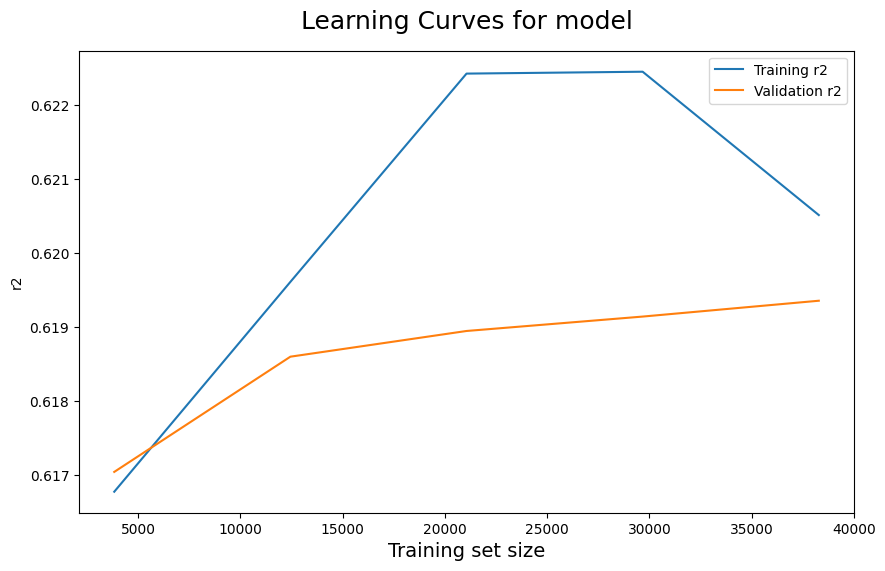

In [ ]:
# Plot learning curves for the optimized model
plot_learning_curves(optimized_model, X_train, y_train, scoring='r2')

Linear Regression Mean Squared Error: 0.11714067650912165
Linear Regression R-squared: 0.6221958582210162


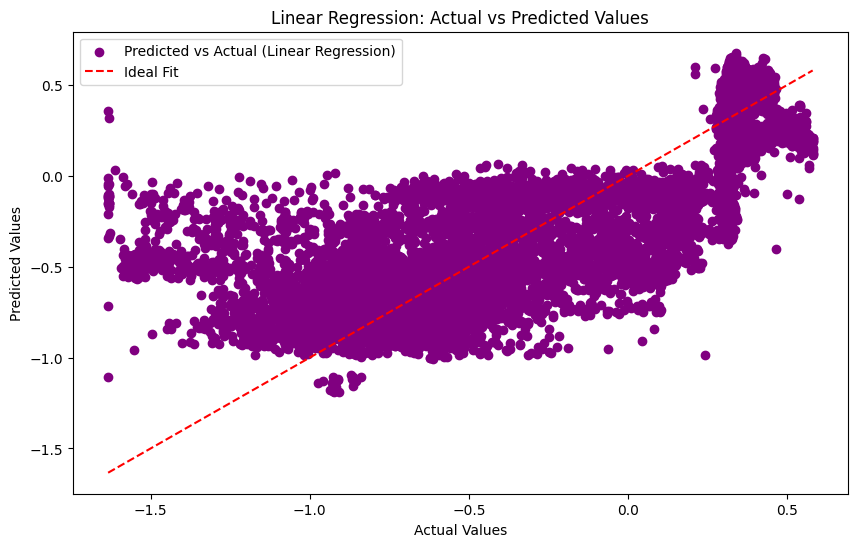

In [ ]:
optimized_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = optimized_model.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Print metrics
print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression R-squared: {r2_lr}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, color='purple', label='Predicted vs Actual (Linear Regression)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted Values')
plt.legend()
plt.show()

### 3.2.- SVM

In [ ]:
y_train = y_train.values.ravel()  # Convert DataFrames to 1D array
y_test = y_test.values.ravel()

In [ ]:
# Define the SVR model
svm_model = SVR()

# Set a hyperparameter grid for SVR
svm_grid_values = {
    'model__kernel': ['linear', 'poly', 'rbf'],  # Kernel functions
    'model__C': [0.1, 1, 10],
    'model__epsilon': [0.1, 0.2, 0.5],
    'model__gamma': ['scale', 'auto']
}

# Perform hyperparameter optimization
optimized_svm_model = optimize_hyperparameters(
    X_train,
    y_train,
    model=svm_model,
    model_grid_values=svm_grid_values,
    scoring='r2',
    cv_splits=3
)

Best hyperparameters:
{'model__C': 1, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

Available metrics in grid search results:
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__C', 'param_model__epsilon', 'param_model__gamma',
       'param_model__kernel', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

Scoring metric 'r2' not found. Available metrics:
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__C', 'param_model__epsilon', 'param_model__gamma',
       'param_model__kernel', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_trai

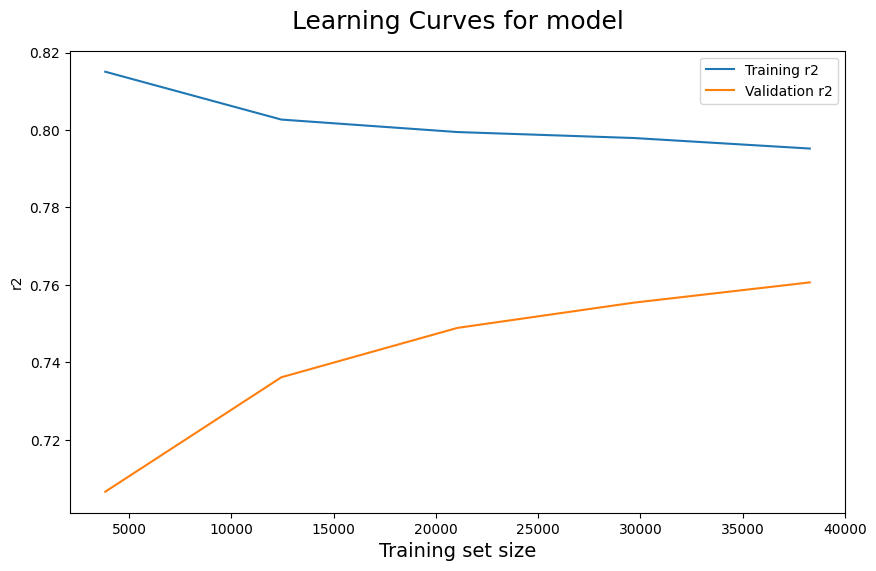

In [ ]:
# Create a new pipeline with the best hyperparameters
best_svm_pipeline = define_pipeline(
    model=SVR(C=1, epsilon=0.1, gamma='scale', kernel='rbf')
)

# Plot learning curves
plot_learning_curves(best_svm_pipeline, X_train, y_train, scoring='r2')

SVR Mean Squared Error: 0.07126483462658342
SVR R-squared: 0.7701554192149386


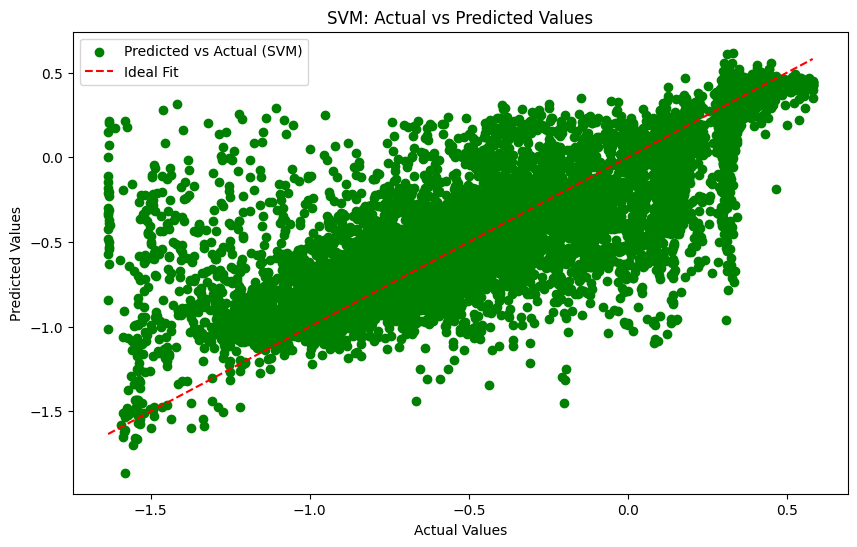

In [ ]:
# Fit the pipeline on the training data
best_svm_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = best_svm_pipeline.predict(X_test)

# Evaluate
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print(f"SVR Mean Squared Error: {mse_svm}")
print(f"SVR R-squared: {r2_svm}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svm, color='green', label='Predicted vs Actual (SVM)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVM: Actual vs Predicted Values')
plt.legend()
plt.show()


### 3.3.- K-NN

In [ ]:
# Define the K-NN model
knn_model = KNeighborsRegressor()

# Set a hyperparameter grid for K-NN
knn_grid_values = {
    'model__n_neighbors': [3, 5, 10, 15],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__p': [1, 2]
}

# Perform hyperparameter optimization
optimized_knn_model = optimize_hyperparameters(
    X_train,
    y_train,
    model=knn_model,
    model_grid_values=knn_grid_values,
    scoring='r2',
    cv_splits=3
)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

Best hyperparameters:
{'model__algorithm': 'auto', 'model__n_neighbors': 10, 'model__p': 1, 'model__weights': 'distance'}

Available metrics in grid search results:
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__algorithm', 'param_model__n_neighbors', 'param_model__p',
       'param_model__weights', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

Scoring metric 'r2' not found. Available metrics:
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__algorithm', 'param_model__n_neighbors', 'param_model__p',
       'param_model__weights', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', '

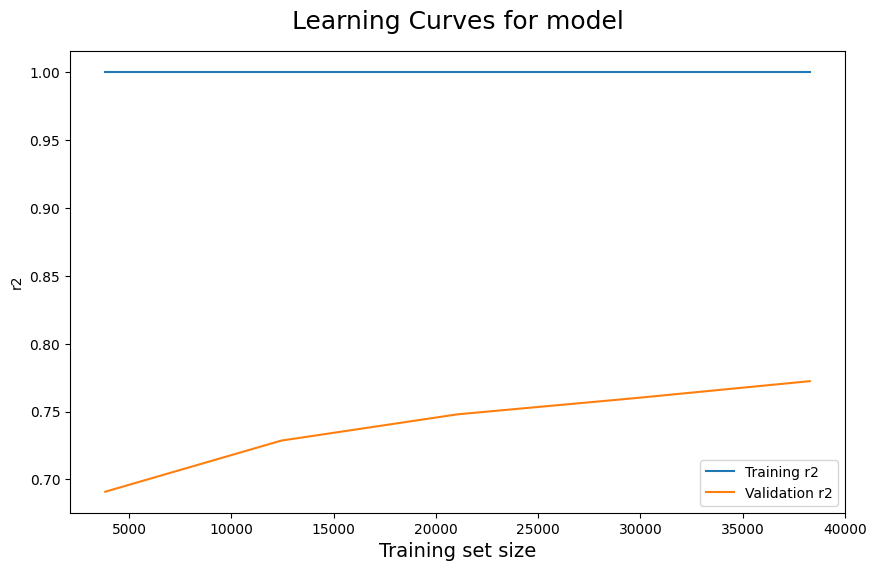

In [ ]:
# Create a new pipeline with the best hyperparameters for KNN
best_knn_pipeline = define_pipeline(
    model=KNeighborsRegressor(
        algorithm='auto',
        n_neighbors=10,
        p=1,
        weights='distance'
    )
)

# Plot learning curves
plot_learning_curves(best_knn_pipeline, X_train, y_train, scoring='r2')

Mean Squared Error: 0.06807949571774566
R-squared: 0.7804288295160559


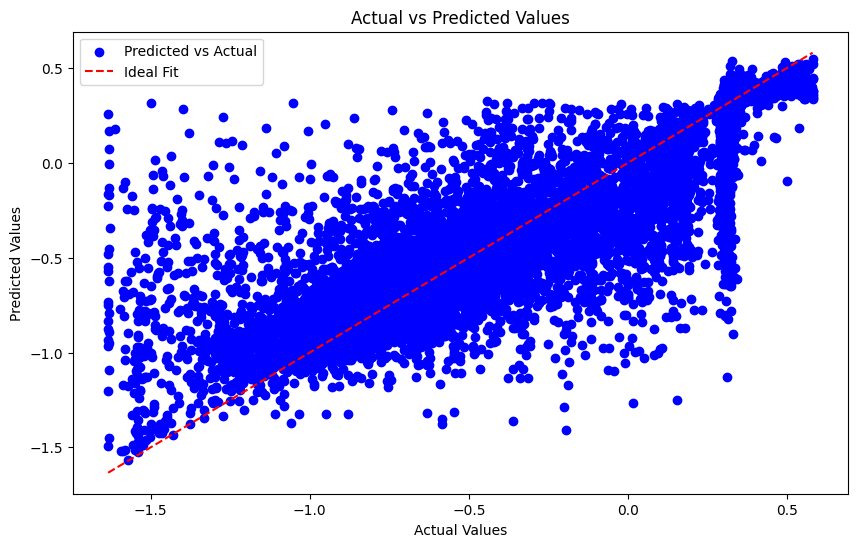

In [ ]:
# Predict on the test set
y_pred = best_knn_pipeline.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


### 3.4.- Random Forest

In [ ]:
# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Set a wide hyperparameter grid
rf_grid_values = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [True, False],
    'model__criterion': ['squared_error', 'absolute_error']
}

# Perform hyperparameter optimization
optimized_rf_model = optimize_hyperparameters(X_train, y_train, model=rf_model, model_grid_values=rf_grid_values)

Best hyperparameters:
{'model__bootstrap': False, 'model__criterion': 'squared_error', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}

Available metrics in grid search results:
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__bootstrap', 'param_model__criterion',
       'param_model__max_depth', 'param_model__max_features',
       'param_model__min_samples_leaf', 'param_model__min_samples_split',
       'param_model__n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

Scoring metric 'neg_mean_squared_error'

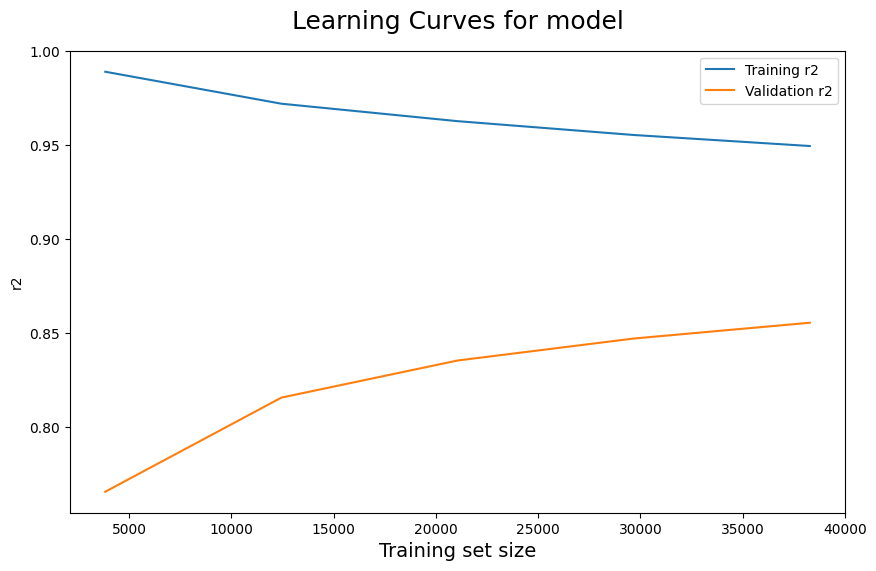

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        bootstrap=False,
        criterion='squared_error',
        max_depth=20,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=100,
        random_state=42
    ))
])

# Plot learning curve
plot_learning_curves(pipeline, X_train, y_train, scoring='r2')

Random Forest Mean Squared Error: 0.04234545365710133
Random Forest R-squared: 0.8634267083482557


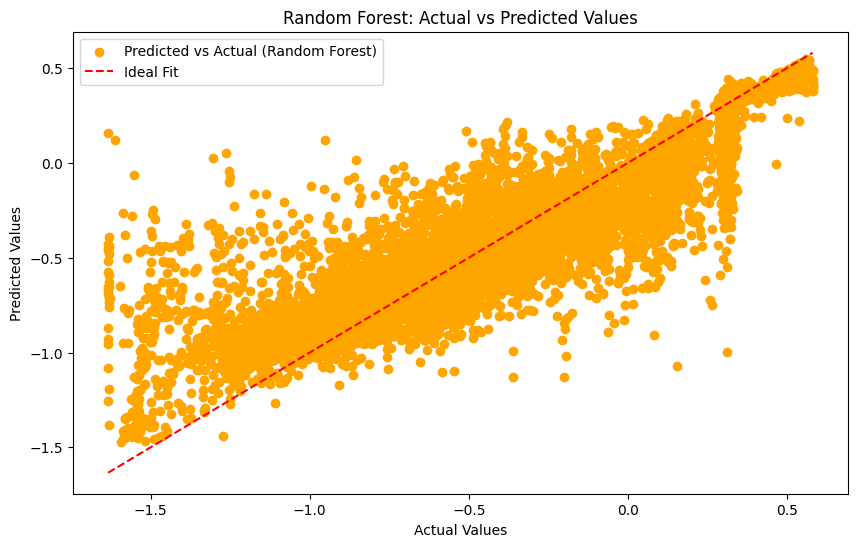

In [ ]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict with test set
y_pred_rf = pipeline.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R-squared: {r2_rf}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='orange', label='Predicted vs Actual (Random Forest)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted Values')
plt.legend()
plt.show()

After noticing the better results from random forest we also check for the most important variables in the model.

In [ ]:
# Extract the trained model from the pipeline
rf_model = pipeline.named_steps['model']

# Get feature importances from the model
importances = rf_model.feature_importances_


numerical_feature_names = numerical_features
categorical_feature_names = list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

# Combine the feature names
all_feature_names = numerical_feature_names + categorical_feature_names

# Create a DataFrame with feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                     Feature  Importance
47             sensor_code_C    0.276289
46             sensor_code_B    0.240833
3   atmospheric_pressure_raw    0.087209
0               humidity_raw    0.070584
5                battery_raw    0.051748
2        air_temperature_raw    0.047827
45             sensor_code_A    0.039832
48             sensor_code_D    0.021752
11                   month_9    0.019119
1             wind_speed_raw    0.017376
9                    month_7    0.016154
7                    month_5    0.014279
10                   month_8    0.012435
8                    month_6    0.008605
43                 range_6.0    0.006065
42                 range_5.0    0.005622
12                  month_10    0.005092
44                 range_7.0    0.003708
40                 range_3.0    0.003603
38                 range_1.0    0.003075
37                 range_0.0    0.002417
39                 range_2.0    0.002408
4          precipitation_raw    0.002230
22              

<ipython-input-48-bf7221bfe7be>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")


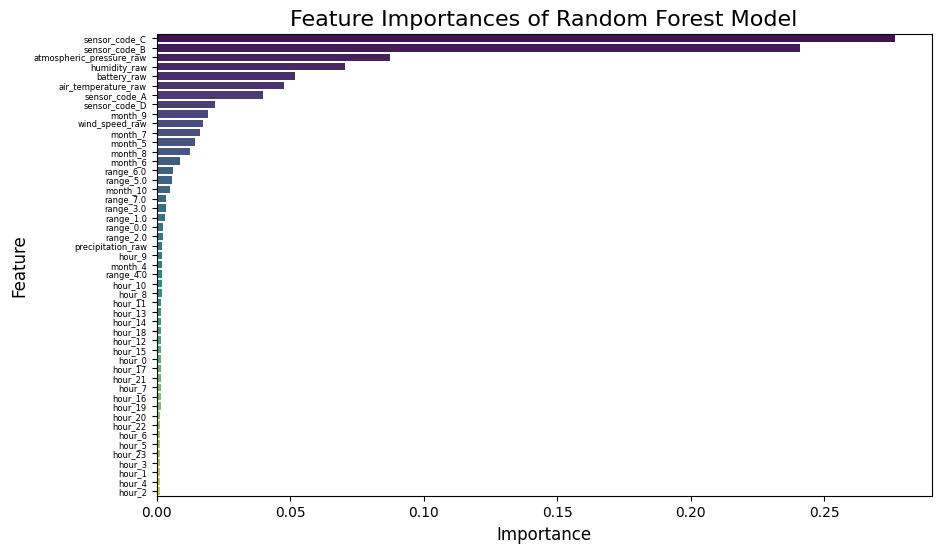

In [ ]:
# Create the plot with gradient color
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")

plt.title('Feature Importances of Random Forest Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tick_params(axis='y', labelsize=6)
plt.show()

<ipython-input-45-d9881851b4dc>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10_features, palette="viridis")


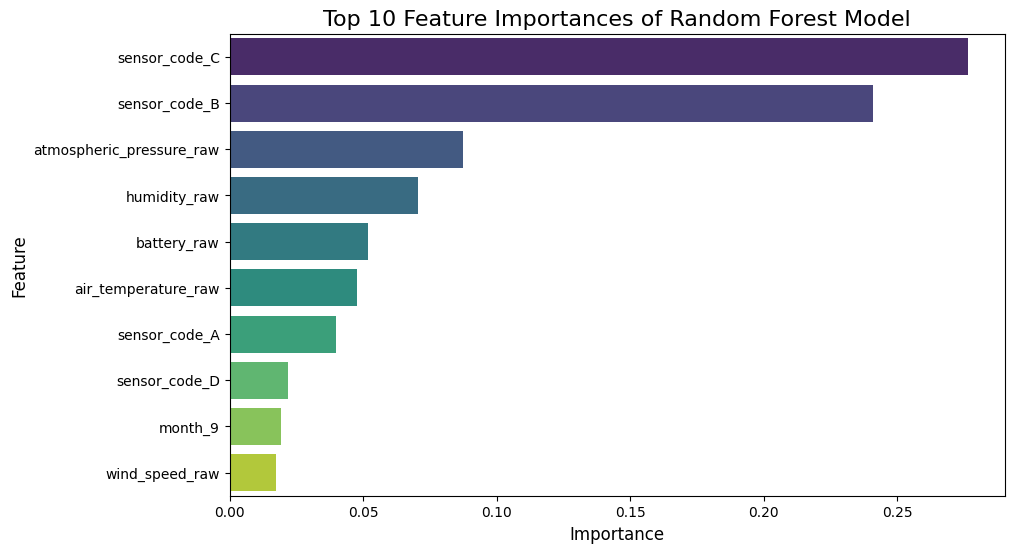

In [ ]:
# Select top 10
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette="viridis")
plt.title('Top 10 Feature Importances of Random Forest Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()